In [287]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)


sys.path.append('../')
import xai
from xai.xdata import XData
from importlib import reload
reload(xai)
reload(xai.xdata)
import xai
from xai.xdata import XData

In [288]:
csv_path = 'data/adult.data'
csv_columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country", "loan"]

In [289]:
df = pd.read_csv(csv_path, names=csv_columns)

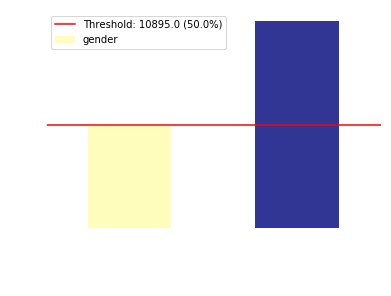

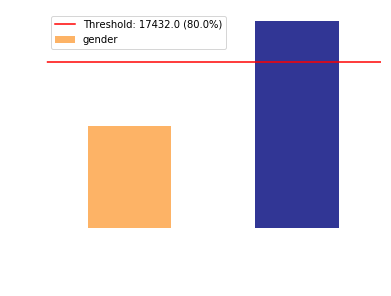

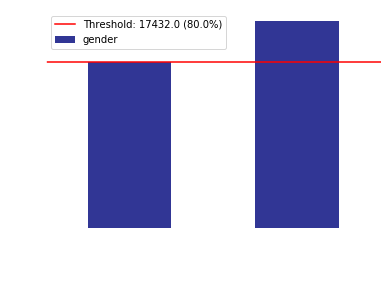

In [291]:
xd = XData("loan", df)
# xd.imbalances(plot=True)
xd.show_imbalance("gender")
xd.set_threshold(0.8)
xd.show_imbalance("gender")
xd.balance("gender")
xd.show_imbalance("gender")

xd.show_imbalance


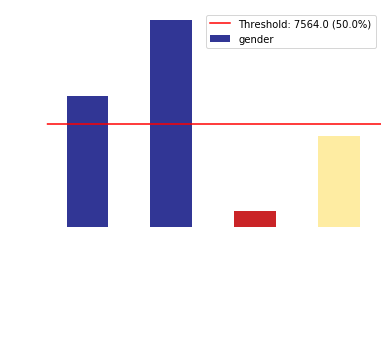

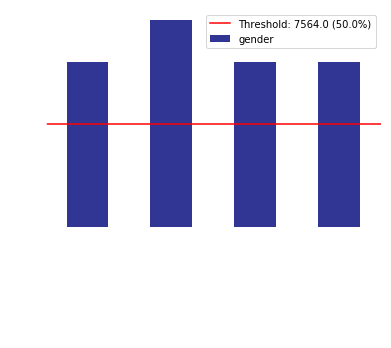

[None]


In [217]:
def plot_imbalance(x, y, raw_ratios, under_thresholds, threshold):
    y_max = y.max()
    cm = plt.cm.get_cmap('RdYlBu_r')
    # 0.5-> 1.0 and below is orange->red. We want to start orange from threshold
    colors = [cm(1-r/threshold/2) if t else cm(0) \
               for r,t in zip(raw_ratios, under_thresholds)]
    kwargs = {}
    if type(x[1]) is not str:
        kwargs["width"] = x[1]-x[0]
    plt.bar(x, y, color=colors, **kwargs)
    lp = plt.axhline(threshold*y_max, color='r')
    lp.set_label(f"Threshold: {threshold*y_max} ({threshold*100}%)")
    plt.xticks(x, x, rotation='vertical')
    plt.legend()
    plt.show()

def class_imbalance(
        df, 
        column_name, 
        threshold=0.5, 
        bins=10, 
        plot=False,
        cross_column_names=[]):
    kwargs = {}
    # Check if column is a string/object or numeric
    if df[column_name].dtype == np.object:
        x = np.array(df[column_name].value_counts().index)
        y = df[column_name].value_counts().values
    else:
        x = df[column_name].value_counts(bins=bins).index.map(lambda x: x.left)
        y = df[column_name].value_counts(bins=bins).values
        # Convert to pairs, sort, and split again to two arrays
        x, y = zip(*sorted(zip(x, y)))
        x = np.array(x, dtype=np.float32)
        y = np.array(y, dtype=np.float32)

    y_max = y.max()
    under_thresholds = []
    raw_ratios = []
    
    for val in y:
        under_threshold = False
        raw_ratio = val/y_max
        if raw_ratio < threshold:
            under_threshold = True
        
        raw_ratios.append(raw_ratio)
        under_thresholds.append(under_threshold)
        

    if plot:
        plot_imbalance(x, y, raw_ratios, under_thresholds, threshold)
    
    return x, y, under_thresholds, raw_ratios


def group_by_columns(df, all_cols, bins):
    group_list = []
    for c in all_cols:
        col = df[c]
        if col.dtype == np.object or not bins:
            grp = c
        else:
            col_min = col.min()
            col_max = col.max()
            col_bins = pd.cut(col, list(range(col_min, col_max, 
                int((col_max-col_min)/bins))))
            grp = col_bins

        group_list.append(grp)

    grouped = df.groupby(group_list)
    return grouped 

def class_imbalance(
        df, 
        column_name, 
        threshold=0.5, 
        bins=10, 
        plot=False,
        cross_column_names=[]):
    
    
    all_cols = cross_column_names + [column_name]
    grouped = group_by_columns(df, all_cols, bins)
    grouped_col = grouped[column_name]
    count_grp = grouped_col.count()
    count_max = count_grp.values.max()
    ratios = count_grp/count_max
    imbalances = ratios < threshold
    
    if plot:
        cm = plt.cm.get_cmap('RdYlBu_r')
        colors = [cm(1-r/threshold/2) if t else cm(0) \
                   for r,t in zip(ratios, imbalances)]
        ax = count_grp.plot.bar(color=colors)
        lp = plt.axhline(threshold*count_max, color='r')
        lp.set_label(f"Threshold: {threshold*count_max} ({threshold*100}%)")
        plt.legend()
        plt.show()
        
    return None


def class_imbalances(
        df, 
        threshold=0.5, 
        bins=10, 
        plot=False, 
        column_names=[],
        cross_column_names=[]):
    
    # TODO: Ensure column_names and cross_column_names are part of df.columns
    if not column_names:
        column_names = [x for x in list(df.columns) if x not in cross_column_names]
    else:
        if any([x in column_names for x in cross_column_names]):
            raise("Error: Columns in 'cross_column_names' are also in 'column_names'")
    
    imbalances = []
    for col in column_names:
        imbalance = class_imbalance(
            df, 
            col, 
            bins=bins, 
            threshold=threshold, 
            plot=plot,
            cross_column_names=cross_column_names)
        imbalances.append(imbalance)
    
    return imbalances


def balance_classes(
        df, 
        column_name, 
        cross_column_names=[], 
        target_upsample=0.5,
        target_downsample=1,
        bins=None):
    
    all_cols = cross_column_names + [column_name]
    grouped = group_by_columns(df, all_cols, bins)
    
    count_grp = grouped.count()
    count_max = count_grp.values.max()
    count_upsample = int(target_upsample*count_max)
    count_downsample = int(target_downsample*count_max)
    
    def norm(x):
        if x.shape[0] < count_upsample:
            return x.sample(count_upsample, replace=True)
        elif x.shape[0] > count_downsample:
            return x.sample(count_downsample)
        else:
            return x
    
    balanced_df = grouped.apply(norm) \
                .reset_index(drop=True)
    
    return balanced_df


cis = class_imbalances(
    df, 
    plot=True, 
    column_names=["gender"],
    cross_column_names=["loan"])

new_df = balance_classes(
    df, 
    "gender", 
    target_upsample=0.8,
    target_downsample=1,
    cross_column_names=["loan"])

cis = class_imbalances(
    new_df, 
    plot=True, 
    column_names=["gender"],
    cross_column_names=["loan"])


print(cis)

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'ethnicity',
 'gender',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country',
 'loan']

898


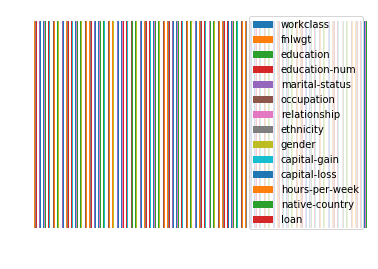

In [172]:
grp = df.groupby("age")
count_grp = grp.count()
count_max = count_grp.values.max()
print(count_max)
target_upsample=1
target_downsample=1
count_upsample = int(target_upsample*count_max)
count_downsample = int(target_downsample*count_max)

def norm(x):
    if x.shape[0] < count_upsample:
        return x.sample(count_upsample, replace=True)
    elif x.shape[0] > count_downsample:
        return x.sample(count_downsample)
    else:
        return x

tmp_df = grp.apply(norm) \
            .reset_index(drop=True)

tmp_df.groupby("age").count().plot.bar()

In [ ]:
def balance_imbalance():
    """
    Paper that talks about imbalance on CNNs
    https://arxiv.org/abs/1710.05381
    """

In [114]:
list(range(10,20,2))

[10, 12, 14, 16, 18]

In [280]:
# df.groupby(["education"])["education"].sum().plot.bar(figsize=(20,20))
print(df.groupby([age_bins])["age"].sum())
print(df.groupby(["education"]))

age
(17, 53]    945483
(53, 89]    300189
Name: age, dtype: int64
